### Inspecting the loss manifold

Let us take a closer look at the network from the previous training.

#### Using the Model class

There are two changes: 

First, we will be using the `Model` class. Here, we use functionality that has not yet been streamlined into the `simulation` interface. This will give us the opportunity to glimpse at the more complex `Model` class and how to work with the neural networks using this interface.


In [1]:
from TATi.model import Model as tati

Second, we will fix the bias degree of freedom of the neural network. This makes it a *constant* parameter that is left unmodified during training or sampling.

As with the `simulation` class so does the `Model` class rely on a set of options.

First, we create the `options` instance of class `PythonOptions` which contains all the options that control the network and the dataset.

In [23]:
from TATi.options.pythonoptions import PythonOptions

options = PythonOptions()
options.set_options(
    batch_data_files=["dataset-twoclusters.csv"],
    fix_parameters="output/biases/Variable:0=-0.045677684",
    output_activation="linear",
    hidden_dimension=[2],
    learning_rate=0.1,
    loss="mean_squared",
    max_steps=1,
    #parse_parameters_file="training.csv",
    #parse_steps=[100],
    seed=426)
print(options.get("input_dimension"), options.get("output_dimension"), options.get("hidden_dimension"))

2 1 [2]


You may wonder what `parse_parameters_file` and `parse_steps` do.

They allow to parse a specific step (it's number in column *step* defined by `parse_steps`) from a CSV file given by `parse_parameters_file`. Here, we use the last step from our training trajectory, i.e. the minimum location.

Next, we pass this `options` to the actual `Model` instance.

In [24]:
nn = tati(options)
nn.init_input_pipeline()
nn.init_network(None, setup=None)

The *input pipeline* which feeds the dataset into the network actually must be created before the network. That's why the network was not created before when we did not specify a dataset.

After having initialized the input pipeline using `init_input_pipeline()`, we need to initialize the network by calling `init_network()`.

Let us check that the *network's parameters* have indeed been parsed from the training file. `Model` does not have a `parameters` data descriptior, but it has `weights` and `biases`. So, let's try.

In [4]:
print(nn.weights, nn.biases)

[<TATi.models.parameters.neuralnet_parameters.neuralnet_parameters object at 0x7f0aa0512fd0>] [<TATi.models.parameters.neuralnet_parameters.neuralnet_parameters object at 0x7f0aa0512d30>]


You may wonder: what does this mean?

All weights and biases are actually nodes inside `tensorflow`'s computational graph. Moreover, there's one weight matrix and one bias vector per layer in the network. Inspecting nodes can only be done by evaluating them. This requires a `tensorflow.Session` object (a temporary workspace).
 
The class `neuralnet_parameters` hides all this complexity and represents all weights together as a single vector. Similary, all biases are represented as a single vector.

> Note that `weights` and `biases` are still lists: There is one per "walker". A walker is a single instantiation of the current network. There may be multiple copies of the graph, each with a different parameter set. See the option `number_walkers`.

In [5]:
print(nn.weights[0].evaluate(nn.sess), nn.biases[0].evaluate(nn.sess))

[0.14639977 0.3271967 ] []


Yes, these are the correct values. Note that the list of biases is empty because the single bias is fixed.

We needed to provide a `Session` object (from `Model.sess()`) to the `evaluate()` function.

#### Sampling with an equidistant grid

Now, we would like to look at the region around the found minimum during our training run before.

For this we will use an equidistant grid and evaluate the loss function at each grid point.

We have ...

In [25]:
print(nn.get_total_weight_dof())

6


... weights and ...

In [7]:
print(nn.get_total_bias_dof())

0


... biases, i.e. 2 parameters in total. Hence, a two-dimensional grid which is easy to plot (that's why we fixed the bias).

In order to evaluate the loss on a grid we instantiate a specific `NaiveGridSampler`.

We do not have to do this directly but there's a helper class called `SamplingModes` that when using its `create()` function will construct the instance for us (*factory pattern*) given some options.

These options are "non-standard" options. However, the `Options` class can easily be extended by new option names using `add()` and `set()` as follows.

In [8]:
from TATi.samplers.grid.samplingmodes import SamplingModes

more_options = {
    "exclude_parameters": [],
    "samples_weights": 10,
    "samples_biases": 1,
    "interval_weights": [-1,1],
    "interval_biases": [-1,1],
}
for k,v in more_options.items():
    if not k in options:
        options.add(k)
    options.set(k, v)

Now, we can use `create()` to instantiate our grid sampler.

In [9]:
# create a "naive_grid" sampler class
grid_sampler = SamplingModes.create("naive_grid", nn, options)

The `grid_sampler` is prepared. 

In [10]:
# we need to set max_steps to the number of grid points
options.max_steps=grid_sampler.get_max_steps()
nn.reset_parameters(options)

# and re-create the input pipeline such that enough batches are present
nn.init_input_pipeline()
nn.reset_dataset()

Excluded 0 parameters from max_steps sampling calculation.


Option `max_steps` is important for the input pipeline as `tensorflow` will prepare as many batches as there are steps. As the number of steps depends on the sampler (and the options we pass), we query it for `get_max_steps()`. Next, we tell our network model `nn` about the change in options and reinitialize the input pipeline.

Now, we use a for loop over the number of steps which equals the number of gridpoints. In the loop body we request the current grid point evaluation.

In [11]:
import numpy as np

def sample_grid(grid_sampler): 
    # set the sampler to the start of the grid
    grid_sampler.goto_start()

    # iterate over every grid point
    coords = []
    losses = []
    for i in range(options.max_steps):
        coords_eval = np.asarray(grid_sampler.set_step())
        loss_eval, acc_eval = grid_sampler.evaluate_loss()
        coords.append(coords_eval)
        losses.append(loss_eval)
        grid_sampler.goto_next_step()
    
    samples = np.zeros((len(coords),coords[0].shape[0]+1))
    samples[:,:-1] = np.asarray(coords)
    samples[:,-1:] = np.asarray(losses)
    return np.asarray(samples)

After the loop is done, we construct a single numpy array as return value.

Then, we call the above defined function `sample_grid()` to perform the grid evaluations.

In [12]:
samples = sample_grid(grid_sampler)
print(samples.shape)

(121, 3)


Let's take a look at the samples.

In [13]:
print(samples[-12:,:])

[[ 1.14639974  1.12719667 13.72064781]
 [-0.85360026  1.32719672  0.51624244]
 [-0.65360022  1.32719672  0.6838485 ]
 [-0.45360023  1.32719672  1.18141556]
 [-0.25360024  1.32719672  2.00894403]
 [-0.05360023  1.32719672  3.16643357]
 [ 0.14639977  1.32719672  4.65388393]
 [ 0.34639975  1.32719672  6.47129536]
 [ 0.54639977  1.32719672  8.61866856]
 [ 0.74639976  1.32719672 11.09600163]
 [ 0.94639975  1.32719672 13.90329742]
 [ 1.14639974  1.32719672 17.04055214]]


Finally, we visualize the sampled grid using `matplotlib` again.

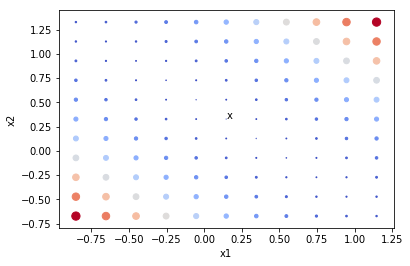

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.scatter(samples[:,0], samples[:,1], c=samples[:,2], s=samples[:,2]*4, cmap=cm.coolwarm)
plt.xlabel("x1")
plt.ylabel("x2")
plt.text(0.14637233, 0.32722256, r'x')
plt.show()


Let us save the sampled grid values for later use as CSV.

In [15]:
np.savetxt("loss-grid.csv", samples, delimiter=",", header=",".join(["x1","x2","loss"]))

### Summary

- how to use and extend `PythonOptions`
- how to generally use the `Model`
- how to instantiate a specific `SamplingMode` for grid-based sampling (can also resample trajectories)
- how to plot the loss the on the grid